## 1. Setup and Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import os
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
from google.colab import drive
import shutil
from pathlib import Path

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Using device: cuda
GPU: Tesla T4
Mounted at /content/drive


## 2. Configuration

In [3]:
class Config:
    """Model and training configuration"""
    # Model architecture
    vocab_size = 50257   # GPT-2 tokenizer vocab size
    embed_dim = 128      # Embedding dimension (64-256)
    n_layers = 2         # Number of transformer layers (1-2)
    n_heads = 4          # Number of attention heads (2-4)
    seq_len = 64         # Sequence length (32-128)
    dropout = 0.1        # Dropout rate

    # Training hyperparameters
    batch_size = 32      # Batch size (16, 32, 64)
    learning_rate = 1e-3 # Learning rate (1e-3, 5e-4)
    num_epochs = 10       # Number of training epochs
    warmup_steps = 500   # Learning rate warmup

    # Paths - UPDATE THESE TO MATCH YOUR ASSIGNMENT 1 OUTPUT
    # For Google Colab with Drive:
    segment_dir = '/content/drive/MyDrive/ML_Assignment_Data/tokenization_segments'

    # For local:
    # segment_dir = './tokenization_segments'

    checkpoint_dir = Path('./checkpoints')
    checkpoint_dir.mkdir(exist_ok=True)

config = Config()
print("Configuration:")
for key, value in vars(config).items():
    print(f"  {key}: {value}")

Configuration:


## 3. Dataset - Compatible with Assignment 1 Segmented Data

In [4]:
class SegmentedTextDataset(Dataset):
    """Dataset for next-token prediction using Assignment 1's segmented data"""

    def __init__(self, segment_dir, seq_len, max_tokens=None):
        """Load tokenized data from Assignment 1 segments

        Args:
            segment_dir: Path to directory containing segment_XXX.pt files
            seq_len: Sequence length for training
            max_tokens: Maximum number of tokens to load (None = all)
        """
        self.segment_dir = segment_dir
        self.seq_len = seq_len

        # Find all segment files
        if not os.path.exists(segment_dir):
            raise ValueError(f"Segment directory not found: {segment_dir}")

        self.segment_files = sorted([
            f for f in os.listdir(segment_dir) if f.endswith('.pt')
        ])

        if not self.segment_files:
            raise ValueError(f"No .pt segment files found in {segment_dir}")

        print(f"Found {len(self.segment_files)} segment files in {segment_dir}")

        # Load all segments and flatten tokens
        self.tokens = []
        total_sequences = 0

        print("Loading segments...")
        for seg_file in tqdm(self.segment_files, desc="Loading segments"):
            seg_path = os.path.join(segment_dir, seg_file)
            seg_data = torch.load(seg_path, map_location='cpu')

            # Each segment contains a list of token sequences
            # Flatten all sequences into one continuous stream
            for sequence in seg_data:
                self.tokens.extend(sequence)

                # Stop if we've reached max_tokens
                if max_tokens and len(self.tokens) >= max_tokens:
                    break

            total_sequences += len(seg_data)
            del seg_data

            if max_tokens and len(self.tokens) >= max_tokens:
                print(f"Stopped at {len(self.tokens):,} tokens (max_tokens limit)")
                break

        print(f"\nDataset Statistics:")
        print(f"  Total tokens: {len(self.tokens):,}")
        print(f"  Original sequences: {total_sequences:,}")
        print(f"  Training sequences (seq_len={seq_len}): {len(self):,}")

    def __len__(self):
        # Each training example needs seq_len+1 tokens (input + target)
        return max(0, (len(self.tokens) - self.seq_len) // self.seq_len)

    def __getitem__(self, idx):
        # Get a chunk of seq_len+1 tokens
        start_idx = idx * self.seq_len
        end_idx = start_idx + self.seq_len + 1

        if end_idx > len(self.tokens):
            # Pad if needed
            chunk = self.tokens[start_idx:]
            chunk = chunk + [0] * (self.seq_len + 1 - len(chunk))
        else:
            chunk = self.tokens[start_idx:end_idx]

        # Input: [0, 1, 2, ..., seq_len-1]
        # Target: [1, 2, 3, ..., seq_len] (next token prediction)
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)

        return x, y


# Load training data
print("Loading training data...\n")

# Option 1: Load all data (may require lots of RAM)
# train_dataset = SegmentedTextDataset(
#     config.segment_dir,
#     config.seq_len
# )

# Option 2: Load subset for faster testing (RECOMMENDED FOR FIRST RUN)
train_dataset = SegmentedTextDataset(
    config.segment_dir,
    config.seq_len,
    max_tokens=10_000_000  # ~10M tokens = ~150K sequences
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoader created with batch_size={config.batch_size}")
print(f"Total batches per epoch: {len(train_loader)}")

Loading training data...

Found 8 segment files in /content/drive/MyDrive/ML_Assignment_Data/tokenization_segments
Loading segments...


Loading segments:   0%|          | 0/8 [00:00<?, ?it/s]

Stopped at 10,000,249 tokens (max_tokens limit)

Dataset Statistics:
  Total tokens: 10,000,249
  Original sequences: 135,756
  Training sequences (seq_len=64): 156,252

DataLoader created with batch_size=32
Total batches per epoch: 4883


## 4. Model Architecture: Mini-GPT

In [5]:
class MultiHeadAttention(nn.Module):
    """Multi-head self-attention layer"""

    def __init__(self, embed_dim, n_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % n_heads == 0, "embed_dim must be divisible by n_heads"

        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads

        # Linear projections for Q, K, V
        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, embed_dim = x.shape

        # Project to Q, K, V
        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch, heads, seq_len, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Apply causal mask
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention to values
        attn_output = torch.matmul(attn_weights, v)

        # Concatenate heads and project
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(batch_size, seq_len, embed_dim)
        output = self.out_proj(attn_output)

        return output


class FeedForward(nn.Module):
    """Position-wise feed-forward network"""

    def __init__(self, embed_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class TransformerBlock(nn.Module):
    """Transformer decoder block"""

    def __init__(self, embed_dim, n_heads, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(embed_dim, n_heads, dropout)
        self.feed_forward = FeedForward(embed_dim, dropout)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention with residual connection
        x = x + self.dropout(self.attention(self.ln1(x), mask))
        # Feed-forward with residual connection
        x = x + self.dropout(self.feed_forward(self.ln2(x)))
        return x


class MiniGPT(nn.Module):
    """Mini-GPT: Small-scale transformer language model"""

    def __init__(self, vocab_size, embed_dim, n_layers, n_heads, seq_len, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.seq_len = seq_len

        # Token and position embeddings
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(seq_len, embed_dim)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, dropout)
            for _ in range(n_layers)
        ])

        # Output layer
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)

        self.dropout = nn.Dropout(dropout)

        # Create causal mask
        self.register_buffer(
            "causal_mask",
            torch.tril(torch.ones(seq_len, seq_len)).view(1, 1, seq_len, seq_len)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        batch_size, seq_len = idx.shape
        assert seq_len <= self.seq_len, f"Sequence length {seq_len} exceeds maximum {self.seq_len}"

        # Token embeddings
        tok_emb = self.token_embedding(idx)  # (batch, seq_len, embed_dim)

        # Position embeddings
        pos = torch.arange(0, seq_len, dtype=torch.long, device=idx.device).unsqueeze(0)
        pos_emb = self.position_embedding(pos)  # (1, seq_len, embed_dim)

        # Combine embeddings
        x = self.dropout(tok_emb + pos_emb)

        # Apply transformer blocks
        mask = self.causal_mask[:, :, :seq_len, :seq_len]
        for block in self.blocks:
            x = block(x, mask)

        # Output logits
        x = self.ln_f(x)
        logits = self.head(x)

        return logits

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Initialize model
model = MiniGPT(
    vocab_size=config.vocab_size,
    embed_dim=config.embed_dim,
    n_layers=config.n_layers,
    n_heads=config.n_heads,
    seq_len=config.seq_len,
    dropout=config.dropout
).to(device)

print(f"\nModel Parameters: {model.count_parameters():,}")
print(f"\nModel Architecture:")
print(model)


Model Parameters: 13,270,784

Model Architecture:
MiniGPT(
  (token_embedding): Embedding(50257, 128)
  (position_embedding): Embedding(64, 128)
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiHeadAttention(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)

## 5. Training Setup

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    betas=(0.9, 0.95),
    weight_decay=0.1
)

# Learning rate scheduler with warmup
def get_lr_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return max(0.1, 1.0 - float(step - warmup_steps) / float(max(1, total_steps - warmup_steps)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

total_steps = len(train_loader) * config.num_epochs
scheduler = get_lr_scheduler(optimizer, config.warmup_steps, total_steps)

print(f"Training configuration:")
print(f"  Total steps: {total_steps:,}")
print(f"  Warmup steps: {config.warmup_steps}")
print(f"  Steps per epoch: {len(train_loader)}")

Training configuration:
  Total steps: 48,830
  Warmup steps: 500
  Steps per epoch: 4883


## 6. Training Functions

In [7]:
def calculate_perplexity(loss):
    """Calculate perplexity from loss"""
    return torch.exp(loss).item()


def train_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_tokens = 0

    progress_bar = tqdm(train_loader, desc="Training")

    for batch_idx, (x, y) in enumerate(progress_bar):
        x, y = x.to(device), y.to(device)

        # Forward pass
        logits = model(x)

        # Compute loss
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        scheduler.step()

        # Track metrics
        total_loss += loss.item() * x.size(0)
        total_tokens += x.size(0)

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'ppl': f'{calculate_perplexity(loss):.2f}',
            'lr': f'{scheduler.get_last_lr()[0]:.6f}'
        })

    avg_loss = total_loss / total_tokens
    return avg_loss


def save_checkpoint(model, optimizer, epoch, loss, filepath):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'config': vars(config)
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to {filepath}")


def load_checkpoint(filepath, model, optimizer=None):
    """Load model checkpoint"""
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"Checkpoint loaded from {filepath}")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Loss: {checkpoint['loss']:.4f}")

    return checkpoint['epoch'], checkpoint['loss']

## 7. Training Loop

In [8]:
# Training history
history = {
    'train_loss': [],
    'train_perplexity': [],
    'learning_rate': []
}

best_loss = float('inf')

print("Starting training...\n")

for epoch in range(config.num_epochs):
    print(f"\nEpoch {epoch + 1}/{config.num_epochs}")
    print("-" * 50)

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion, device)
    train_ppl = calculate_perplexity(torch.tensor(train_loss))

    print(f"\nTrain Loss: {train_loss:.4f} | Train Perplexity: {train_ppl:.2f}")

    # Save best model
    if train_loss < best_loss:
        best_loss = train_loss
        save_checkpoint(
            model, optimizer, epoch + 1, train_loss,
            config.checkpoint_dir / 'mini_gpt_best.pt'
        )

    # Record history
    history['train_loss'].append(train_loss)
    history['train_perplexity'].append(train_ppl)
    history['learning_rate'].append(scheduler.get_last_lr()[0])

    # Save checkpoint every epoch
    save_checkpoint(
        model, optimizer, epoch + 1, train_loss,
        config.checkpoint_dir / f'mini_gpt_epoch_{epoch+1}.pt'
    )

# Save final model
save_checkpoint(
    model, optimizer, config.num_epochs, train_loss,
    config.checkpoint_dir / 'mini_gpt_final.pt'
)

print("\nTraining completed!")

Starting training...


Epoch 1/10
--------------------------------------------------


Training:   0%|          | 0/4883 [00:00<?, ?it/s]


Train Loss: 6.4941 | Train Perplexity: 661.25
Checkpoint saved to checkpoints/mini_gpt_best.pt
Checkpoint saved to checkpoints/mini_gpt_epoch_1.pt

Epoch 2/10
--------------------------------------------------


Training:   0%|          | 0/4883 [00:00<?, ?it/s]


Train Loss: 5.9191 | Train Perplexity: 372.07
Checkpoint saved to checkpoints/mini_gpt_best.pt
Checkpoint saved to checkpoints/mini_gpt_epoch_2.pt

Epoch 3/10
--------------------------------------------------


Training:   0%|          | 0/4883 [00:00<?, ?it/s]


Train Loss: 5.8037 | Train Perplexity: 331.54
Checkpoint saved to checkpoints/mini_gpt_best.pt
Checkpoint saved to checkpoints/mini_gpt_epoch_3.pt

Epoch 4/10
--------------------------------------------------


Training:   0%|          | 0/4883 [00:00<?, ?it/s]


Train Loss: 5.7329 | Train Perplexity: 308.86
Checkpoint saved to checkpoints/mini_gpt_best.pt
Checkpoint saved to checkpoints/mini_gpt_epoch_4.pt

Epoch 5/10
--------------------------------------------------


Training:   0%|          | 0/4883 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ce1bddb20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ce1bddb20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Train Loss: 5.6849 | Train Perplexity: 294.39
Checkpoint saved to checkpoints/mini_gpt_best.pt
Checkpoint saved to checkpoints/mini_gpt_epoch_5.pt

Epoch 6/10
--------------------------------------------------


Training:   0%|          | 0/4883 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ce1bddb20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process



Train Loss: 5.6358 | Train Perplexity: 280.29
Checkpoint saved to checkpoints/mini_gpt_best.pt
Checkpoint saved to checkpoints/mini_gpt_epoch_6.pt

Epoch 7/10
--------------------------------------------------


Training:   0%|          | 0/4883 [00:00<?, ?it/s]


Train Loss: 5.5900 | Train Perplexity: 267.75
Checkpoint saved to checkpoints/mini_gpt_best.pt
Checkpoint saved to checkpoints/mini_gpt_epoch_7.pt

Epoch 8/10
--------------------------------------------------


Training:   0%|          | 0/4883 [00:00<?, ?it/s]


Train Loss: 5.5552 | Train Perplexity: 258.58
Checkpoint saved to checkpoints/mini_gpt_best.pt
Checkpoint saved to checkpoints/mini_gpt_epoch_8.pt

Epoch 9/10
--------------------------------------------------


Training:   0%|          | 0/4883 [00:00<?, ?it/s]


Train Loss: 5.5100 | Train Perplexity: 247.14
Checkpoint saved to checkpoints/mini_gpt_best.pt
Checkpoint saved to checkpoints/mini_gpt_epoch_9.pt

Epoch 10/10
--------------------------------------------------


Training:   0%|          | 0/4883 [00:00<?, ?it/s]


Train Loss: 5.4748 | Train Perplexity: 238.59
Checkpoint saved to checkpoints/mini_gpt_best.pt
Checkpoint saved to checkpoints/mini_gpt_epoch_10.pt
Checkpoint saved to checkpoints/mini_gpt_final.pt

Training completed!


## 8. Visualizations

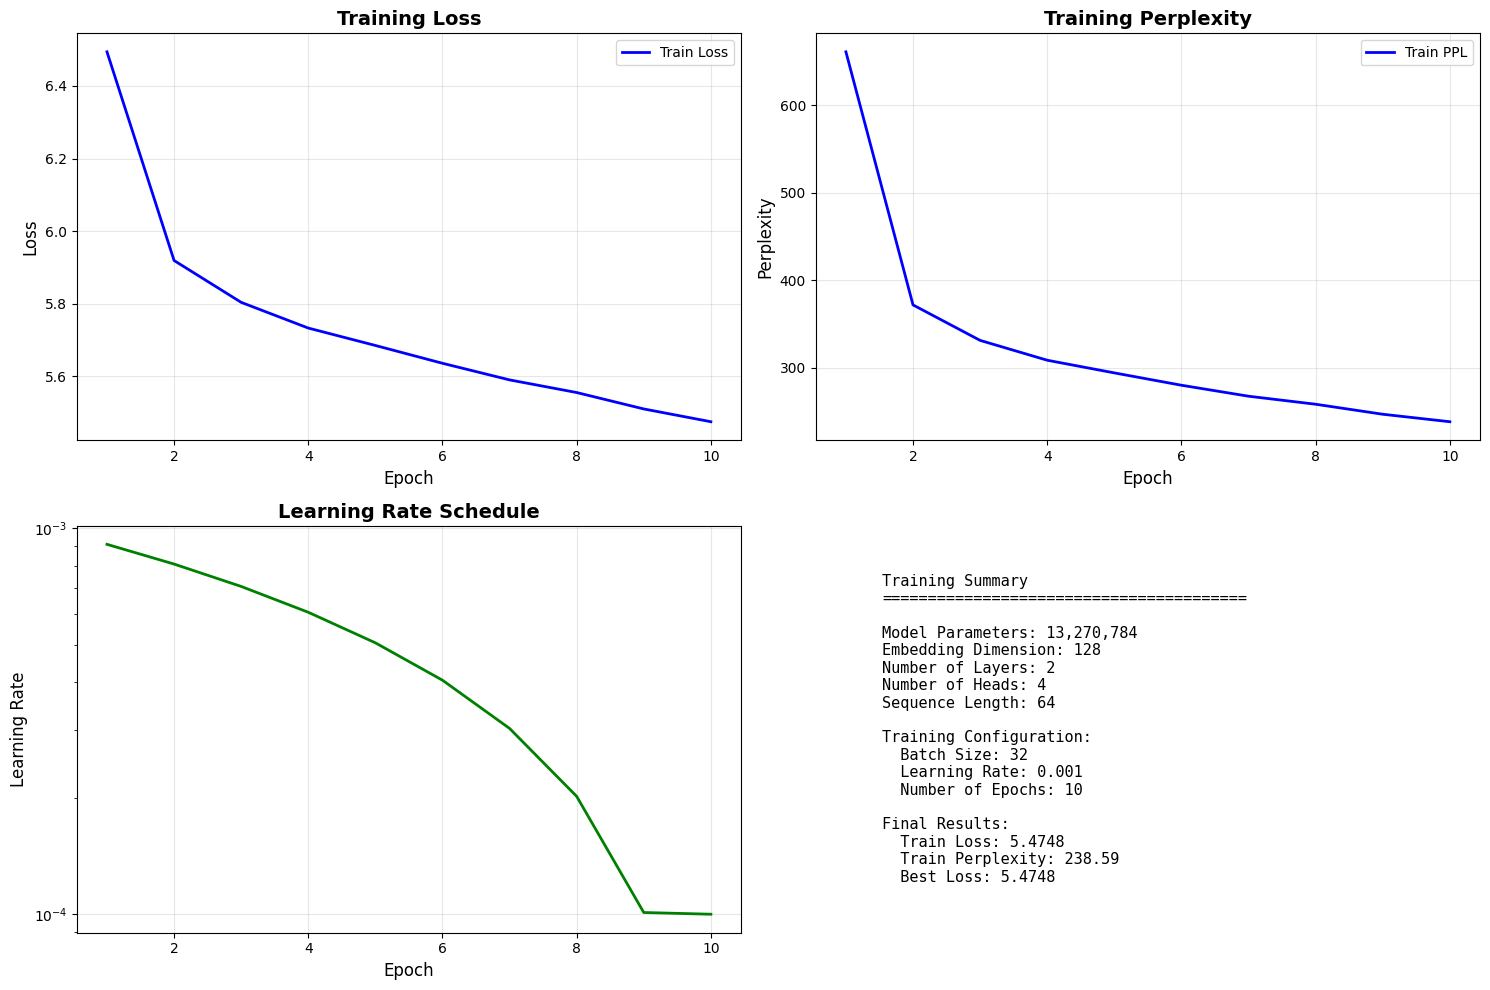


Visualization saved to checkpoints/training_curves.png


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Training Loss
axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Perplexity
axes[0, 1].plot(epochs, history['train_perplexity'], 'b-', label='Train PPL', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Perplexity', fontsize=12)
axes[0, 1].set_title('Training Perplexity', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Learning Rate
axes[1, 0].plot(epochs, history['learning_rate'], 'g-', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

# Summary Statistics
axes[1, 1].axis('off')
summary_text = f"""
Training Summary
{'='*40}

Model Parameters: {model.count_parameters():,}
Embedding Dimension: {config.embed_dim}
Number of Layers: {config.n_layers}
Number of Heads: {config.n_heads}
Sequence Length: {config.seq_len}

Training Configuration:
  Batch Size: {config.batch_size}
  Learning Rate: {config.learning_rate}
  Number of Epochs: {config.num_epochs}

Final Results:
  Train Loss: {history['train_loss'][-1]:.4f}
  Train Perplexity: {history['train_perplexity'][-1]:.2f}
  Best Loss: {best_loss:.4f}
"""

axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig(config.checkpoint_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {config.checkpoint_dir / 'training_curves.png'}")

In [10]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

source_dir = Path('./checkpoints')
drive_dir = Path('/content/drive/MyDrive/ML_Assignment_Data/Assignment2_Checkpoints')

drive_dir.mkdir(parents=True, exist_ok=True)

print("Copying checkpoints to Google Drive...")
for filepath in source_dir.glob('*.pt'):
    dest = drive_dir / filepath.name
    size_mb = filepath.stat().st_size / (1024 * 1024)
    print(f"  → {filepath.name} ({size_mb:.2f} MB)", end='')
    shutil.copy2(filepath, dest)
    print(" ✓")

for filename in ['training_history.csv', 'training_curves.png']:
    if os.path.exists(filename):
        shutil.copy2(filename, drive_dir / filename)
        print(f"  → {filename} ✓")

print(f"\n✓ All files saved to: {drive_dir}")
print("Files will persist after Colab runtime ends!")

Copying checkpoints to Google Drive...
  → mini_gpt_epoch_10.pt (151.92 MB) ✓
  → mini_gpt_epoch_7.pt (151.92 MB) ✓
  → mini_gpt_epoch_3.pt (151.92 MB) ✓
  → mini_gpt_epoch_9.pt (151.92 MB) ✓
  → mini_gpt_best.pt (151.92 MB) ✓
  → mini_gpt_epoch_4.pt (151.92 MB) ✓
  → mini_gpt_epoch_5.pt (151.92 MB) ✓
  → mini_gpt_epoch_2.pt (151.92 MB) ✓
  → mini_gpt_final.pt (151.92 MB) ✓
  → mini_gpt_epoch_8.pt (151.92 MB) ✓
  → mini_gpt_epoch_1.pt (151.92 MB) ✓
  → mini_gpt_epoch_6.pt (151.92 MB) ✓

✓ All files saved to: /content/drive/MyDrive/ML_Assignment_Data/Assignment2_Checkpoints
Files will persist after Colab runtime ends!
